# Population Based Training

## Background
Population Based Training (PBT) as introduced by Jaderberg et al. 2017
is an evolutionary algorithm for hyperparameter search. The diagram below is
taken from Jaderberg et al. 2017 and gives an intuition on the algorithm. It
starts with a random population of hyperparamater
configurations. Each population member is trained for a limited amount
of time and evaluated. When every population member has been evaluated,
the ones with low scores replace their own weights and hyperparameters
with those from population members with high scores (exploit) and
perturb the hyperparameters (explore). Then all population members are
trained and evaluated again and the process repeats. This process achieves a
joint optimization of the model parameters and training hyperparameters.
   
![PBT Diagram from Jaderberg et al. 2017](pbt.png "PBT Diagram from Jaderberg et al. 2017")

Note that only parameters can be tuned that can be changed during training. The
number of layers in a neural network for example is better tuned with e.g. the
[GPyOpt Algorithm](keras_mnist_mlp.ipynb).

In [119]:
import sherpa
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten
from keras.datasets import mnist
from keras.optimizers import Adam
import tempfile
import os
import shutil
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

## Dataset Preparation
Training data is normalized to the [0, 1] range.

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

## Sherpa Setup
We define one hyperparameter `learning_rate`. The algorithms uses a `population_size` of 5. This means the first 5 trials returned by the algorithm are randomly sampled. Each is trained by the user for say one epoch. This is the first generation. After that the 4 best out of these five are returned one after another (the top 80%). The fifth one (bottom 20%) is resampled from the top 20% (here just the best trial from generation 1) and its parameters are perturbed. For perturbation the parameter, here the `learning_rate` is randomly multiplied by 0.8 or 1.2 (as defined by the `perturbation_factors`). After that the next generation evolves in a similar way. The algorithm stops after `num_generations` generations.

In [102]:
parameters = [sherpa.Continuous('learning_rate', [1e-4, 1e-2], 'log')]
algorithm = sherpa.algorithms.PopulationBasedTraining(population_size=5,
                                                      num_generations=5,
                                                      perturbation_factors=(0.8, 1.2),
                                                      parameter_range={'learning_rate': [1e-6, 1e-1]})
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False,
                     dashboard_port=8997)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://128.195.75.106:8997 if on a cluster or
http://localhost:8997 if running locally.
-------------------------------------------------------


Make a temporary directory to store model files in. Population based training jointly optimizes a population of models and their hyperparameters. To train all models *at the same time* we train each model for one epoch (or more if you like), save it (using *trial.parameters['save_to']*), and load it again at a later time when needed (using *trial.parameters['load_from']*). For this reason, we need a directory to save these models in.

In [104]:
model_dir = tempfile.mkdtemp()

## Hyperparameter Optimization
Technically Population Based Training could go on forever, training ever more generations. In reality however we would like to stop at some point. For this reason we set a *max_num_generations*. You can set this to the number of epochs that you would normally train the model for. Here, we choose something small to speed up the example.

In [105]:
for trial in study:
    generation = trial.parameters['generation']
    load_from = trial.parameters['load_from']
    training_lr = trial.parameters['learning_rate']
    
    print("-"*100)
    print("Generation {}".format(generation))
    
    if load_from == "":
        print("Creating new model with learning rate {}\n".format(training_lr))

        # Create model
        model = Sequential([Flatten(input_shape=(28, 28)),
                            Dense(64, activation='relu'),
                            Dense(10, activation='softmax')])
        
        # Use learning rate parameter for optimizer
        optimizer = Adam(lr=training_lr)
        
        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    else:
        print(f"Loading model from ", os.path.join(model_dir, load_from), "\n")
        
        # Loading model
        model = load_model(os.path.join(model_dir, load_from))
        
        if not np.isclose(K.get_value(model.optimizer.lr), training_lr):
            print("Perturbing learning rate from {} to {}".format(K.get_value(model.optimizer.lr), training_lr))
            K.set_value(model.optimizer.lr, training_lr)
        else:
            print("Continuing training with learning rate {}".format(training_lr))
            
    # Train model for one epoch
    model.fit(x_train, y_train)
    loss, accuracy = model.evaluate(x_test, y_test)
    
    print("Validation accuracy: ", accuracy)
    study.add_observation(trial=trial, iteration=generation,
                          objective=accuracy,
                          context={'loss': loss})
    study.finalize(trial=trial)
    
    print(f"Saving model at: ", os.path.join(model_dir, trial.parameters['save_to']))
    model.save(os.path.join(model_dir, trial.parameters['save_to']))
    
    study.save(model_dir)

----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with learning rate 0.0033908174916255636

Epoch 1/1
10000/10000 [==============================] - 1s 117us/step
Validation accuracy:  0.962
Saving model at:  /var/folders/5v/l788ch2j7tg0q0y1rt04c08w0000gn/T/tmpt_1z3upl/1
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with learning rate 0.00024918992981810167

Epoch 1/1
10000/10000 [==============================] - 1s 124us/step
Validation accuracy:  0.9203
Saving model at:  /var/folders/5v/l788ch2j7tg0q0y1rt04c08w0000gn/T/tmpt_1z3upl/2
----------------------------------------------------------------------------------------------------
Generation 1
Creating new model with learning rate 0.006140980350498516

Epoch 1/1
10000/10000 [==============================] - 1s 124us/step
Validation accuracy:  0.9548
Saving model a

Continuing training with learning rate 0.0033908174916255636
Epoch 1/1
10000/10000 [==============================] - 1s 148us/step
Validation accuracy:  0.9659
Saving model at:  /var/folders/5v/l788ch2j7tg0q0y1rt04c08w0000gn/T/tmpt_1z3upl/17
----------------------------------------------------------------------------------------------------
Generation 4
Loading model from  /var/folders/5v/l788ch2j7tg0q0y1rt04c08w0000gn/T/tmpt_1z3upl/14 ...

Continuing training with learning rate 0.0010303357974986642
Epoch 1/1
10000/10000 [==============================] - 2s 185us/step
Validation accuracy:  0.9711
Saving model at:  /var/folders/5v/l788ch2j7tg0q0y1rt04c08w0000gn/T/tmpt_1z3upl/18
----------------------------------------------------------------------------------------------------
Generation 4
Loading model from  /var/folders/5v/l788ch2j7tg0q0y1rt04c08w0000gn/T/tmpt_1z3upl/15 ...

Continuing training with learning rate 0.004882777187940811
Epoch 1/1
10000/10000 [=========================

The best found hyperparameter configuration is:

In [126]:
study.get_best_result()

{'Iteration': 5,
 'Objective': 0.9734,
 'Trial-ID': 21,
 'generation': 5,
 'learning_rate': 0.002712653993300451,
 'lineage': '1,6,12,20,',
 'load_from': '20',
 'loss': 0.09256360807713354,
 'save_to': '21'}

This model is stored at:

In [107]:
print(os.path.join(model_dir, study.get_best_result()['save_to']))

/var/folders/5v/l788ch2j7tg0q0y1rt04c08w0000gn/T/tmpt_1z3upl/21


These are plots of the evolution of validation accuracy and log learning rates. Lines of equal color indicate that these belong to equal seed trials, that is they stem from the same population member from the first generation.

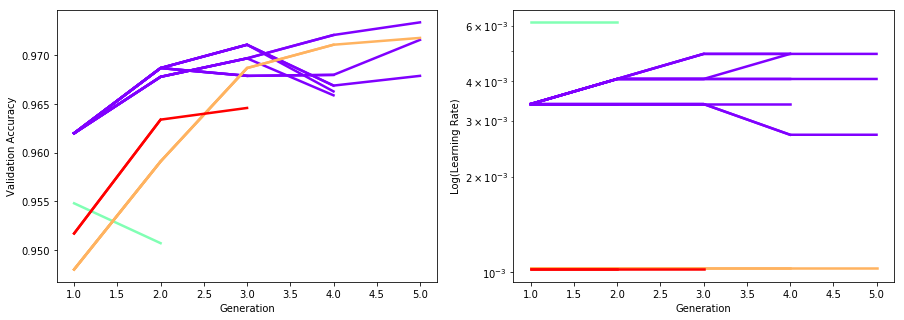

In [125]:
completed = study.results.query("Status == 'COMPLETED'")
fig, axis = plt.subplots(ncols=2, figsize=(15, 5))
n = 5
color=cm.rainbow(np.linspace(0,1,n))
for j in range(1, n+1):
    descendents = completed[(completed['lineage'].str.startswith('{},'.format(j)).fillna(False))]
    for i, row in descendents.iterrows():
        x = list(range(1, len(row['lineage'].split(","))+1))
        obj = []
        lr = []
        for tid in row['lineage'].split(",")[:-1]:
            obj.append(completed.loc[completed['Trial-ID']==int(tid)]['Objective'].values[0])
            lr.append(completed.loc[completed['Trial-ID']==int(tid)]['learning_rate'])
        obj.append(row['Objective'])
        lr.append(row['learning_rate'])
        axis[0].plot(x, obj, '-', color=color[j-1], linewidth=2.5)
        axis[1].plot(x, lr, '-', color=color[j-1], linewidth=2.5)
axis[0].set_xlabel("Generation")
axis[0].set_ylabel("Validation Accuracy")
axis[1].set_xlabel("Generation")
axis[1].set_ylabel("Log(Learning Rate)")
axis[1].set_yscale('log')

To remove the model directory:

In [103]:
# Remove model_dir
shutil.rmtree(model_dir)